<a href="https://colab.research.google.com/github/grmounica/Deep-Learning-Lab-Practice-work/blob/main/AutoEncoders_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)
Epoch 1/50
235/235 [==============================] - 4s 6ms/step - loss: 0.6953 - val_loss: 0.6952
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6952 - val_loss: 0.6950
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6950 - val_loss: 0.6949
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6948 - val_loss: 0.6947
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6947 - val_loss: 0.6945
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6945 - val_loss: 0.6944
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6943 - val_loss: 0.6942
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6942 - val_loss: 0.6940
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6940 - val_loss: 0.6939
Epoch 10/

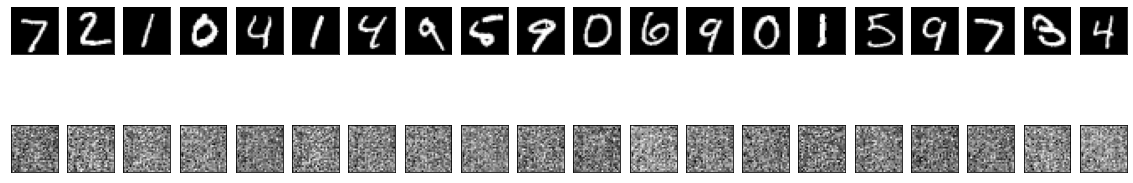

In [1]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt

# this is the size of encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
# configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# prepare our input data. We're using MNIST digits, and we're discarding the labels
(x_train, _), (x_test, _) = mnist.load_data()
# normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

# train our autoencoder for 50 epochs
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# visualize the reconstructed inputs and the encoded representations.use Matplotlib
n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [2]:
# The above reconstructed output is hazy, so we use conv nets for images as below

In [5]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

decoded_imgs = autoencoder.predict(x_test)

Epoch 1/50
469/469 [==============================] - 6s 12ms/step - loss: 0.6591 - val_loss: 0.6508
Epoch 2/50
469/469 [==============================] - 5s 10ms/step - loss: 0.6466 - val_loss: 0.6323
Epoch 3/50
469/469 [==============================] - 5s 10ms/step - loss: 0.6253 - val_loss: 0.6018
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.5911 - val_loss: 0.5593
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 0.5478 - val_loss: 0.5252
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.5190 - val_loss: 0.5125
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.5078 - val_loss: 0.5070
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.5032 - val_loss: 0.5021
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.4974 - val_loss: 0.4968
Epoch 10/50
469/469 [==============================] - 5s 11ms/step - loss: 0.4919 - val_lo

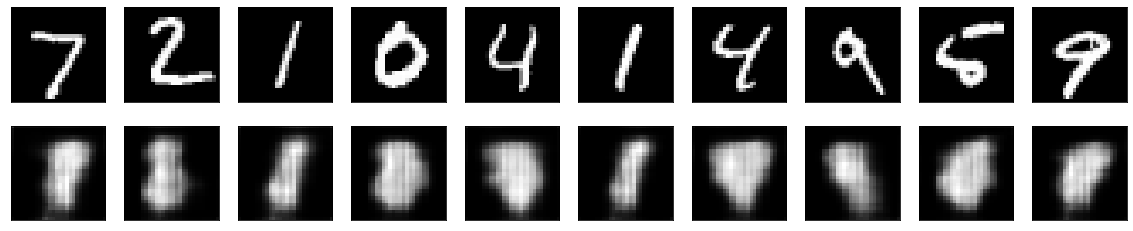

In [6]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
## The above image reconstructed is better than the previous hazy version

**Denoising the image**

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

decoded_imgs = autoencoder.predict(x_test)


Epoch 1/100
469/469 [==============================] - 8s 15ms/step - loss: 0.7062 - val_loss: 0.6833
Epoch 2/100
469/469 [==============================] - 6s 13ms/step - loss: 0.6743 - val_loss: 0.6430
Epoch 3/100
469/469 [==============================] - 6s 13ms/step - loss: 0.6270 - val_loss: 0.5719
Epoch 4/100
469/469 [==============================] - 6s 13ms/step - loss: 0.5524 - val_loss: 0.5171
Epoch 5/100
469/469 [==============================] - 6s 13ms/step - loss: 0.5093 - val_loss: 0.5025
Epoch 6/100
469/469 [==============================] - 6s 13ms/step - loss: 0.4967 - val_loss: 0.4918
Epoch 7/100
469/469 [==============================] - 6s 13ms/step - loss: 0.4846 - val_loss: 0.4763
Epoch 8/100
469/469 [==============================] - 6s 13ms/step - loss: 0.4696 - val_loss: 0.4583
Epoch 9/100
469/469 [==============================] - 6s 13ms/step - loss: 0.4505 - val_loss: 0.4390
Epoch 10/100
469/469 [==============================] - 6s 13ms/step - loss: 0.430

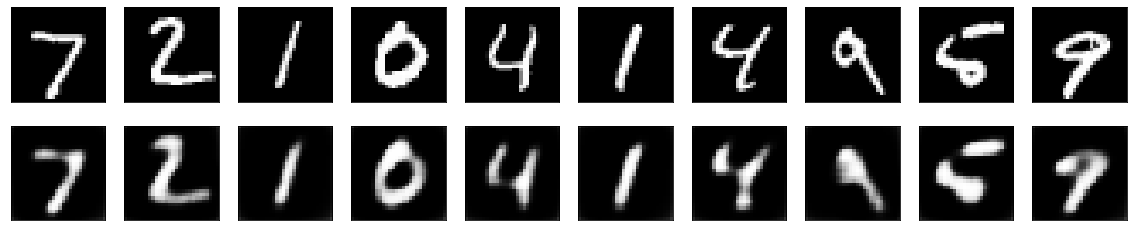

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()